In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("darkgrid")
matplotlib.rc('font', size=20)
matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('figure', titlesize=20)
%matplotlib inline

In [55]:
train_df = pd.read_csv("/Users/sominwadhwa/Work/Kaggle_Data/Russian Housing Market/train.csv"
                      , parse_dates = ['timestamp'])
test_df = pd.read_csv("/Users/sominwadhwa/Work/Kaggle_Data/Russian Housing Market/test.csv",
                     parse_dates = ['timestamp'])
macro_df = pd.read_csv("/Users/sominwadhwa/Work/Kaggle_Data/Russian Housing Market/macro.csv",
                      parse_dates = ['timestamp'])

In [56]:
train_df = pd.merge(train_df,macro_df,on='timestamp', how='left')
test_df = pd.merge(test_df,macro_df,on='timestamp',how='left')
print (train_df.shape,test_df.shape)

(30471, 391) (7662, 390)


In [57]:
print (train_df.info(),test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30471 entries, 0 to 30470
Columns: 391 entries, id to apartment_fund_sqm
dtypes: datetime64[ns](1), float64(213), int64(159), object(18)
memory usage: 91.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7662 entries, 0 to 7661
Columns: 390 entries, id to apartment_fund_sqm
dtypes: datetime64[ns](1), float64(210), int64(161), object(18)
memory usage: 22.9+ MB
None None


##### Label Encoding
Why not OHE? OHE has a the advantage that the result is binary rather than ordinal and that everything sits in an orthogonal vector space. The disadvantage (in this particular case) is that of high cardinality, the feature space will really blow up quickly and I'll end up fighting with the curse of dimensionality. Another typical alternative can be to use OHE followed by PCA, but since features like `sub_area` can take a range of value, we'll avoid OHE altogether.

In [58]:
from sklearn.preprocessing import LabelEncoder

In [59]:
label = LabelEncoder()
for f in train_df.columns:
    if train_df[f].dtype=='object':
        print(f)
        label.fit(list(train_df[f].values.astype('str')) + list(test_df[f].values.astype('str')))
        train_df[f] = label.transform(list(train_df[f].values.astype('str')))
        test_df[f] = label.transform(list(test_df[f].values.astype('str')))

product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology
child_on_acc_pre_school
modern_education_share
old_education_build_share


Since there are some null values in the dataset, a common approach is fill them by the mean or median (avoiding outliers) of their respective columns.

In [60]:
train_df.fillna(train_df.mean(), inplace=True)
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,1,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,2,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,3,2011-08-27,43,29.0,2.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,4,2011-09-01,89,50.0,9.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,5,2011-09-05,77,77.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


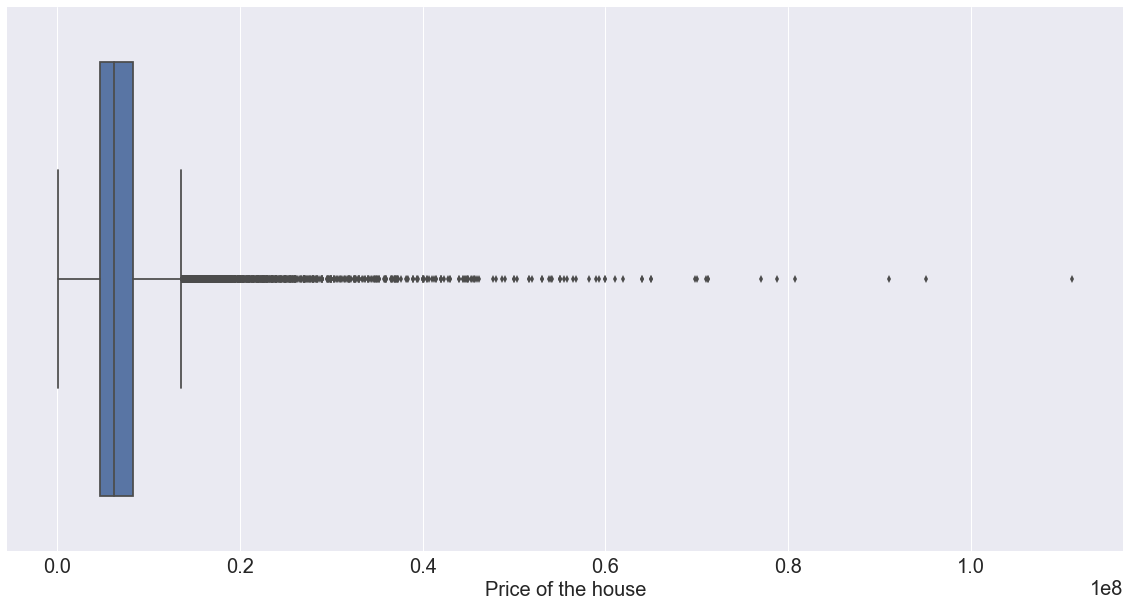

In [61]:
plt.figure(figsize=(20,10))
price = train_df.loc[:,['price_doc','id']]
sns.boxplot(x=price['price_doc'])
plt.xlabel("Price of the house")
q1 = price['price_doc'].quantile(0.25)
q3 = price['price_doc'].quantile(0.75)
iqr = q3 - q1

#### Removing the outliers

In [62]:
threshold_upper = q3 + 1.5*iqr 
threshold_lower = q1- 1.5*iqr
price_new = price.loc[(price['price_doc'] < threshold_upper) & (price['price_doc'] > threshold_lower)]
print ("IQR = ",(iqr))
print("Upper threshhold :",threshold_upper)
print("Lower threshhold :",threshold_lower)
print("Mean",price_new['price_doc'].mean())

IQR =  3559998.0
Upper threshhold : 13639997.0
Lower threshhold : -599995.0
Mean 6275929.181888139


#### Feature Engineering

Based on `timestamp`

In [63]:
train_df["year"] = train_df["timestamp"].dt.year
test_df["year"] = test_df["timestamp"].dt.year
train_df["month_of_year"] = train_df["timestamp"].dt.month
test_df["month_of_year"] = test_df["timestamp"].dt.month
train_df["week_of_year"] = train_df["timestamp"].dt.weekofyear
test_df["week_of_year"] = test_df["timestamp"].dt.weekofyear
train_df["day_of_week"] = train_df["timestamp"].dt.weekday
test_df["day_of_week"] = test_df["timestamp"].dt.weekday
train_df["age_of_building"] = train_df["build_year"] - train_df["year"]
test_df["age_of_building"] = test_df["build_year"] - test_df["year"]
train_df["yearmonth"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.month
test_df["yearmonth"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.month
train_df["yearweek"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.weekofyear
test_df["yearweek"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.weekofyear

Since, by common sense, `area` is a major prospectus in determining the price we try to create some interesting variable attributes around it

In [64]:
train_df["ratio_kitch_sq_life_sq"] = train_df["kitch_sq"] / train_df["life_sq"].astype("float64")
test_df["ratio_kitch_sq_life_sq"] = test_df["kitch_sq"] / test_df["life_sq"].astype("float64")
train_df["ratio_kitch_sq_full_sq"] = train_df["kitch_sq"] / train_df["full_sq"].astype("float64")
test_df["ratio_kitch_sq_full_sq"] = test_df["kitch_sq"] / test_df["full_sq"].astype("float64")
train_df["ratio_life_sq_full_sq"] = train_df["life_sq"] / train_df["full_sq"].astype("float64")
test_df["ratio_life_sq_full_sq"] = test_df["life_sq"] / test_df["full_sq"].astype("float64")
train_df["extra_sq"] = train_df["full_sq"] - train_df["life_sq"]
test_df["extra_sq"] = test_df["full_sq"] - test_df["life_sq"]

Since there is no direct attribute to measure height of the building, but surely there is some information about `floors`, leverage it

In [65]:
train_df["floor_from_top"] = train_df["max_floor"] - train_df["floor"]
test_df["floor_from_top"] = test_df["max_floor"] - test_df["floor"]
train_df["ratio_floor_max_floor"] = train_df["floor"] / train_df["max_floor"].astype("float64")
test_df["ratio_floor_max_floor"] = test_df["floor"] / test_df["max_floor"].astype("float64")

Looking at future prospectus -- `school`

In [66]:
train_df["ratio_preschool"] = train_df["children_preschool"] / train_df["preschool_quota"].astype("float")
test_df["ratio_preschool"] = test_df["children_preschool"] / test_df["preschool_quota"].astype("float")
train_df["ratio_school"] = train_df["children_school"] / train_df["school_quota"].astype("float")
test_df["ratio_school"] = test_df["children_school"] / test_df["school_quota"].astype("float")

Will keep adding more of these...

#### Model Building (xgb)

In [67]:
import xgboost as xgb

In [68]:
train_df.drop(['id','timestamp'], axis=1, inplace=True)
test_df.drop('timestamp',axis=1,inplace=True)

In [69]:
msk = np.random.rand(len(train_df)) < 0.8
train = train_df[msk]
cv = train_df[~msk]

In [70]:
X_train = train.drop('price_doc', axis=1)
y_train = np.log1p(train['price_doc'])
X_cv = cv.drop('price_doc',axis=1)
y_cv = np.log1p(cv['price_doc'])
X_test = test_df.drop('id', axis=1)

In [71]:
print(X_train.shape, y_train.shape,X_cv.shape,y_cv.shape)

(24329, 403) (24329,) (6142, 403) (6142,)


In [72]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'min_child_weight':1,
    'silent': 1,
    'seed':0
}
xgtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
xgtest = xgb.DMatrix(X_cv, y_cv, feature_names=X_cv.columns.values)
watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
num_rounds = 800
model = xgb.train(xgb_params, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=5)

[0]	train-rmse:14.3704	test-rmse:14.3515
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[5]	train-rmse:11.1253	test-rmse:11.1068
[10]	train-rmse:8.61515	test-rmse:8.5976
[15]	train-rmse:6.67441	test-rmse:6.65802
[20]	train-rmse:5.1747	test-rmse:5.15893
[25]	train-rmse:4.01607	test-rmse:4.00194
[30]	train-rmse:3.12294	test-rmse:3.11065
[35]	train-rmse:2.43552	test-rmse:2.42507
[40]	train-rmse:1.90762	test-rmse:1.89942
[45]	train-rmse:1.50503	test-rmse:1.49963
[50]	train-rmse:1.20013	test-rmse:1.19793
[55]	train-rmse:0.972296	test-rmse:0.97375
[60]	train-rmse:0.805025	test-rmse:0.810519
[65]	train-rmse:0.684569	test-rmse:0.694805
[70]	train-rmse:0.600069	test-rmse:0.614828
[75]	train-rmse:0.542312	test-rmse:0.56139
[80]	train-rmse:0.503493	test-rmse:0.526472
[85]	train-rmse:0.478449	test-rmse:0.504639
[90]	train-rmse:0.462202	test-rmse:0.491128
[95]	train-rmse:0.451429	test-rmse:0.482714
[100]

In [73]:
dtest = xgb.DMatrix(test_df.drop('id',axis=1), feature_names=test_df.drop('id',axis=1).columns.values)
y_pred = np.expm1(model.predict(dtest))
df_sub = pd.DataFrame({'id': test_df['id'], 'price_doc': y_pred})
df_sub.to_csv('sub4.csv', index=False)